<a href="https://colab.research.google.com/github/Alejandro-ZZ/Deep-Learning/blob/master/Neural_network_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural network using Numpy**

In [2]:
from sklearn.datasets import make_gaussian_quantiles
import matplotlib.pyplot as plt
import numpy as np

## **1. Dataset creation**

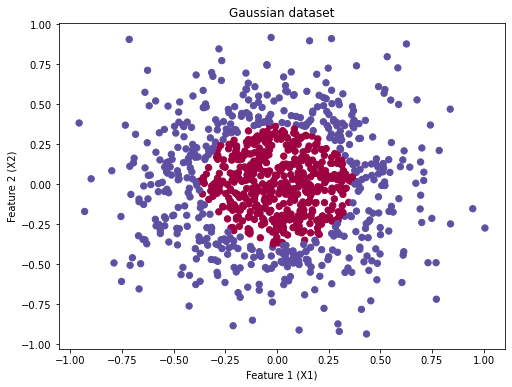

In [58]:
# The total number of points equally divided among classes.
N = 1000

# Generate isotropic Gaussian and label samples by quantile.
gaussian_quantiles = make_gaussian_quantiles(cov=0.1, n_samples=N,
                                             n_features=2, n_classes=2, 
                                             shuffle=True)

# Unpack data and labels
X_train, y_train = gaussian_quantiles

# Change array from (N, ) to (N, 1) 
y_train = y_train[:, np.newaxis]

plt.figure(figsize=(8, 6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train[:,0], s=40, cmap=plt.cm.Spectral)
plt.title('Gaussian dataset')
plt.xlabel('Feature 1 (X1)')
plt.ylabel('Feature 2 (X2)')
plt.show()

## **2. Parameters initialization**

Function to initialize random weights and bias for the neural network.

In [59]:
def initialize_params(layer_dims):
  '''
  Create random weights and bias for a neural network.
  
  Input
  -----
  layer_dims: List of int 
              List with the layers dimentions.
  
  Output
  ------
  out: Dict(String, numpy.array)
       { W1: [...],
         b1: [...],
         W2: [...],
         b2: [...],
         ...
         Wn: [...],
         bn: [...]}
  '''
  # Output parameters
  parameters = {}

  # Total number of layers
  L = len(layer_dims)
  
  # Weight and bias are not generated for the output layer
  for l in range(0, L-1):

    # Random Values are multiplied by 2 and subtracted by 1 
    # to be in the dataset range [-1, 1]
    parameters['W' + str(l+1)] = (np.random.rand(layer_dims[l], layer_dims[l+1]) * 2) - 1
    parameters['b' + str(l+1)] = (np.random.rand(1, layer_dims[l+1]) * 2) - 1

  return parameters

## **3. Activation functions**

In [60]:
def sigmoid(x, derivate=False):
    if derivate:
        return np.exp(-x)/(( np.exp(-x) +1)**2)
    else:    
        return 1 / (1 + np.exp(-x))

def relu(x, derivate=False):
    if derivate:
        x[x<=0] = 0
        x[x>0] = 1
        return x
    else:    
        return np.maximum(0,x)

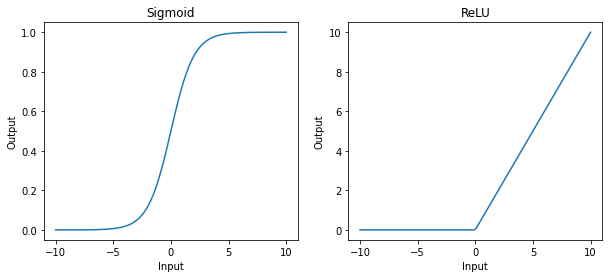

In [62]:
# Visualization
input = np.linspace(10, -10, 100)

figure = plt.figure(figsize=(10, 4))

figure.add_subplot(1, 2, 1)
plt.title('Sigmoid')
plt.xlabel('Input')
plt.ylabel('Output')
plt.plot(input, sigmoid(input))

figure.add_subplot(1, 2, 2)
plt.title('ReLU')
plt.xlabel('Input')
plt.ylabel('Output')
plt.plot(input, relu(input))

plt.show()

## **4. Loss function**

In [63]:
def mse(y, y_hat, derivate=False):
    if derivate:
        return (y_hat - y)
    else:            
        return np.mean((y_hat - y)**2)
    

## **5. Neural Network**

In [65]:
def neural_network(X, params, train=False, lr=None, y=None):
  '''
  Forwdward and backpropagation of a neural network with four layers.

      Input layer:    two neurons (two input features)
      Hidden layer 1: four neurons
      Hidden layer 2: eight neurons
      Output layer:   one neuron (binary output)

  Input
  -----
  X: numpy.array
     Input features
  
  params: Dict(String, numpy.array)
          Weights (Wn) and bias (bn) of each layer.
  
  train: Bool, default=False
         Wether to train or not the neural network.

  lr: Float, default=None
      Learning rate on backpropagation.

  y: numpy.array, default=None
     True values of input data (X).
  '''
  # -------------------------   Forward   -------------------------
  # Input data (A0)
  params['A0'] = X

  # INPUT LAYER
  # Z1 = (A0 ⋅ W1) + b1
  # A1 = ReLU(Z1)
  params['Z1'] = np.matmul(params['A0'], params['W1']) + params['b1']
  params['A1'] = relu(params['Z1'])
  
  # HIDDEN LAYER 1
  # Z2 = (A1 ⋅ W2) + b2
  # A2 = ReLU(Z2)
  params['Z2'] = np.matmul(params['A1'], params['W2']) + params['b2']
  params['A2'] = relu(params['Z2'])

  # HIDDEN LAYER 2
  # Z3 = (A2 ⋅ W3) + b3
  # A3 = Sigmoid(Z3)
  params['Z3'] = np.matmul(params['A2'], params['W3']) + params['b3']
  params['A3'] = sigmoid(params['Z3'])
  
  # OUTPUT LAYER
  output = params['A3']


  if train:
    if (y is None) or (lr is None):
      raise ValueError("Missing `y` and/or `lr` parameters when training.")

    # -------------------------   Backpropagation   -------------------------
    params['dZ3'] =  mse(y, output, derivate=True) * sigmoid(params['A3'], derivate=True)
    params['dW3'] = np.matmul(params['A2'].T, params['dZ3'])
    
    params['dZ2'] = np.matmul(params['dZ3'], params['W3'].T) * relu(params['A2'], derivate=True)
    params['dW2'] = np.matmul(params['A1'].T, params['dZ2'])
    
    params['dZ1'] = np.matmul(params['dZ2'], params['W2'].T) * relu(params['A1'], derivate=True)
    params['dW1'] = np.matmul(params['A0'].T, params['dZ1'])


    # -------------------------   Gradinet Descent   -------------------------
    params['W3'] = params['W3'] - params['dW3'] * lr
    params['b3'] = params['b3'] - (np.mean(params['dZ3'], axis=0, keepdims=True)) * lr
    
    params['W2'] = params['W2'] - params['dW2'] * lr
    params['b2'] = params['b2'] - (np.mean(params['dZ2'], axis=0, keepdims=True)) * lr
    
    params['W1'] = params['W1'] - params['dW1'] * lr
    params['b1'] = params['b1'] - (np.mean(params['dZ1'], axis=0, keepdims=True)) * lr
    
  return output

## **6. Model training**

In [66]:
# Neural network with 4 layer
#     - Input layer: two neurons (two input features)
#     - Hidden layer 1: four neurons
#     - Hidden layer 2: eight neurons
#     - Output layer: one neuron (binary output)
layer_dims = [2, 4, 8, 1]

# Get initial parameters
params = initialize_params(layer_dims)
params

{'W1': array([[-0.46621543, -0.8879494 , -0.05774885, -0.90012193],
        [-0.96136235, -0.28401746, -0.37572518, -0.13506141]]),
 'b1': array([[-0.2530111 ,  0.19123808, -0.33749902, -0.57269566]]),
 'W2': array([[ 0.26451813, -0.39830687, -0.59709624, -0.96384868,  0.73666464,
          0.25690798,  0.57528838, -0.89567855],
        [-0.29961233,  0.15150627,  0.29948071,  0.91422685, -0.14383239,
          0.03170702, -0.7481034 ,  0.70733781],
        [ 0.16360478,  0.69966619, -0.80796117,  0.07292372, -0.89421626,
          0.07463617, -0.91152338,  0.82443113],
        [ 0.28503795, -0.09475743,  0.60674469, -0.33064024, -0.55205775,
          0.7158256 , -0.55774809,  0.13046009]]),
 'b2': array([[-0.32065006, -0.33552025, -0.24389413,  0.76985568, -0.15005055,
         -0.54131951,  0.83945474,  0.32695573]]),
 'W3': array([[-0.06339402],
        [ 0.85162899],
        [-0.01427355],
        [ 0.85566485],
        [-0.92088062],
        [ 0.07603791],
        [-0.42730666],


In [68]:
# --------------------   Hyperparameters   --------------------
# Forward and backward pass of ALL training samples
num_epochs = 30000

# Step size at each iteration while moving toward a 
# minimum of a loss function
learning_rate = 0.001

# --------------------   Training Loop   --------------------
errors = []
for epoch in range(num_epochs):
    output = neural_network(X_train, params, train=True, lr=learning_rate, y=y_train)

    # Print and save error every 25 epoch
    if epoch % 25 == 0:
      error = mse(y,output)
      print(f'Epoch [{epoch} / {num_epochs}] Error: {error}')
      errors.append(error)

Epoch [0 / 30000] Error: 0.16722260721501386
Epoch [25 / 30000] Error: 0.16459848990596856
Epoch [50 / 30000] Error: 0.1623611200039531
Epoch [75 / 30000] Error: 0.16042749586009689
Epoch [100 / 30000] Error: 0.15833759308934367
Epoch [125 / 30000] Error: 0.15605322337888725
Epoch [150 / 30000] Error: 0.15295807149435642
Epoch [175 / 30000] Error: 0.14846437626093636
Epoch [200 / 30000] Error: 0.14218107317756384
Epoch [225 / 30000] Error: 0.13315230271959877
Epoch [250 / 30000] Error: 0.12075596611256813
Epoch [275 / 30000] Error: 0.10588814786783082
Epoch [300 / 30000] Error: 0.0911923856438676
Epoch [325 / 30000] Error: 0.07973650959202269
Epoch [350 / 30000] Error: 0.07205587586657272
Epoch [375 / 30000] Error: 0.06685104941338044
Epoch [400 / 30000] Error: 0.06329784315155676
Epoch [425 / 30000] Error: 0.060709036229684876
Epoch [450 / 30000] Error: 0.05881513279693544
Epoch [475 / 30000] Error: 0.057322392934777824
Epoch [500 / 30000] Error: 0.05611741730090151
Epoch [525 / 30000

### Training curve

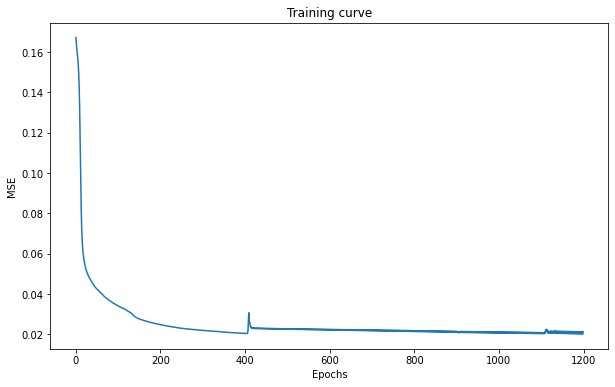

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(errors)
plt.title('Training curve')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

## **7. Model testing**

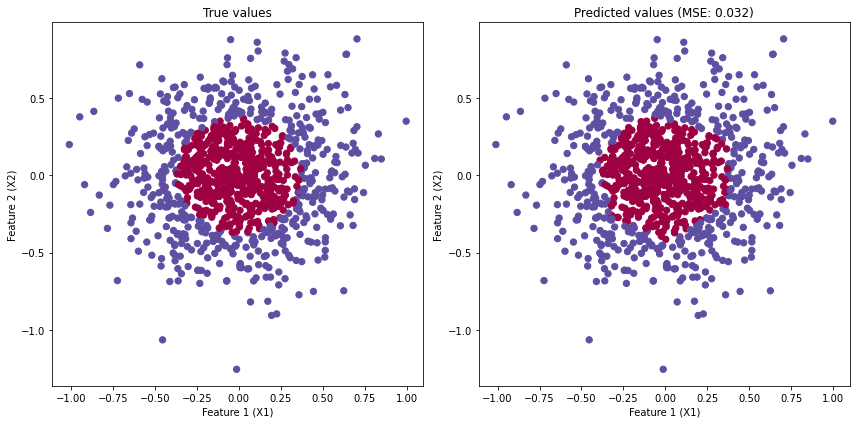

In [91]:
# 1000 data points to test
X_test, y_test = make_gaussian_quantiles(cov=0.1, n_samples=1000,
                                             n_features=2, n_classes=2, 
                                             shuffle=True)
y_test = y_test[:, np.newaxis]

# Predict labels
y_hat = neural_network(X_test, params)
y_hat = np.where(y_hat >= 0.5, 1, 0)

# Visualization
figure = plt.figure(figsize=(12, 6))

figure.add_subplot(1, 2, 1)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test[:,0], s=40, cmap=plt.cm.Spectral)
plt.title('True values')
plt.xlabel('Feature 1 (X1)')
plt.ylabel('Feature 2 (X2)')

figure.add_subplot(1, 2, 2)
plt.scatter(X_test[:,0], X_test[:,1], c=y_hat[:,0], s=40, cmap=plt.cm.Spectral)
plt.title(f'Predicted values (MSE: {mse(y_test, y_hat)})')
plt.xlabel('Feature 1 (X1)')
plt.ylabel('Feature 2 (X2)')

plt.tight_layout()
plt.show()